In [47]:
import numpy as np
import scipy.optimize
from py_vlasov.util import zp, kzkp, list_to_complex, real_imag
from py_vlasov.wrapper import oblique_wrapper, disp_det, input_gen
from py_vlasov.transport_ratios import transport_ratios
from py_vlasov.follow_parameter import follow_k
import matplotlib.pyplot as plt
import matplotlib as mpl
from util import (
    gen_input_file_text,
    get_wave_number, 
    get_initial_guess, 
    get_setup, 
    get_accuracy, 
    get_species,
    write_input_data,
    read_disp_data,
)
import subprocess

mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['xtick.minor.size'] = 3.5
mpl.rcParams['ytick.minor.size'] = 3.5
mpl.rcParams['xtick.major.width'] = 1.1
mpl.rcParams['ytick.major.width'] = 1.1
mpl.rcParams['xtick.minor.width'] = .8
mpl.rcParams['ytick.minor.width'] = .8
mpl.rcParams['legend.fontsize'] = 14
#xtick.major.size     : 3.5      # major tick size in points
#xtick.minor.size     : 2      # minor tick size in points
#xtick.major.width    : 0.8    # major tick width in points
#xtick.minor.width    : 0.6    # minor tick width in points

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def fast_freq_fn(k, theta, betap):
    kz, kp = kzkp(k, theta)
    cos_theta = kz / k
    kdi = k / np.sqrt(betap)
    return kdi * np.sqrt(1 + kdi**2 * cos_theta**2)

def ea_freq_fn(k, theta, aol, the_tp, nc_nh):
    kz, kp = kzkp(k, theta)
    mp_me = 1836
    num = kz * np.sqrt(0.5 * nc_nh/(1+nc_nh) * the_tp * mp_me)
    k_rhose_2 = kp**2 * 0.5 * nc_nh/(1+nc_nh) * the_tp / mp_me
    kp_debye_2 = (kz**2+kp**2) * 0.5 * aol**2 * the_tp
    denom = np.sqrt(1 + k_rhose_2 + kp_debye_2)
    print(denom)
    return num / denom

def kdi_2_krhoi(kdi, betap):
    return kdi * np.sqrt(betap)

# my own solver

In [8]:
theta = 5.
wpe_wce = 4
th_tp = 60
fac = 0.6

# ===============

aol = 1/np.sqrt(1836)/wpe_wce
betap = 1/th_tp * np.cos(np.deg2rad(theta))**2 * 2* fac**2

print('aol = {0:.4g}'.format(aol))
print('beta_p = {0:.3g}'.format(betap))
print('beta_e = {0:.3g}'.format(betap * th_tp))

aol = 0.005835
beta_p = 0.0119
beta_e = 0.715


In [119]:
tc_th = 1/900
nh_n0 = 0.65

t_list=[1., th_tp, th_tp * tc_th]
a_list=[1., 2, 1.]
n_list=[1., nh_n0, 1-nh_n0] 
q_list=[1.,-1., -1.]
m_list=[1., 1./1836., 1./1836]
v_list=[0.,0.,0.]
n = 15
method = 'pade'

kdi = 10

target_kde = 3.
target_kdi = target_kde * np.sqrt(1836)
print('target kdi = {0:.3g}'.format(target_kdi))

k = kdi_2_krhoi(kdi, betap)
kz, kp = kzkp(k, theta)

param = [kz, kp, betap, t_list, a_list, n_list, q_list,
         m_list, v_list, n, method, aol]

target kdi = 129


In [120]:
target_k = kdi_2_krhoi(target_kdi, betap)

# ELECTRON ACOUSTIC MODE

ea_seed_freq = ea_freq_fn(k, theta, aol, the_tp, nc_nh=n_list[2]/n_list[1])
f = lambda wrel:\
    real_imag(disp_det(list_to_complex(wrel), kz, kp, betap,
                              t_list, a_list, n_list, q_list, \
                              m_list, v_list, method = 'numpy', n = 6, \
                              aol=aol))
ea_guess = ea_seed_freq * (1-.5j)

print('ea_seed_freq = {0:.3g}'.format(ea_guess))

wr, wi = scipy.optimize.fsolve(f, real_imag(ea_guess))

print('wr = {0:.3g}'.format(wr))
print('wi = {0:.3g}'.format(wi))
print(r'wr/wce/cos(theta) = {0:.3g}'.format(wr/1836/np.cos(np.deg2rad(theta))))

ea_freq = follow_k(ea_guess, target_k, param,
                log_incrmt = 0.02, incrmt_method = 'log')

1.0006337569223782
ea_seed_freq = 151-75.4j
wr = 152
wi = -64.9
wr/wce/cos(theta) = 0.0833


## DSHARK

In [114]:
input_params = {}
input_params['kstart'] = 10
input_params['kend'] = 80
input_params['nk'] = 110
input_params['nspecies'] = 3
input_params['theta'] = 5
input_params['q_in'] = np.array([1., -1., -1.])
input_params['mu_in'] = np.array([1., 1836., 1836.])
input_params['dens_in'] = np.array([1., .65, .35])
vdc_va = 0.
input_params['drift_in'] = np.array([
    0., vdc_va, 
    -input_params['dens_in'][1]/input_params['dens_in'][2]*vdc_va
])
t_in = np.array([1, 60, 1/15])
beta_0 = 0.0119
a = np.array([1.0, 2., 1.0])
input_params['beta_para_in'] = beta_0 * t_in * input_params['dens_in'] 
input_params['beta_perp_in'] = beta_0 * t_in * input_params['dens_in'] * np.array(a)
input_params['kappa_in'] = np.array([50, 50, 50])
input_params['delta'] = 0.005835

input_params['omega_r'] = 150
input_params['omega_i'] = -65
input_params['increment_r'] = 0 
input_params['increment_i'] = 0

In [109]:
input_file_text = gen_input_file_text(input_params)
write_input_data(input_file_text)
subprocess.run(["./dsolve"])
dshark_ea = read_disp_data()

### whistler

In [115]:
whistler_input_params = input_params.copy()
kdi = whistler_input_params['kstart']
cos_theta = np.cos(np.deg2rad(whistler_input_params['theta']))
whistler_input_params['omega_r'] = kdi * np.sqrt(1 + kdi**2 * cos_theta**2)
whistler_input_params['omega_i'] = 0

In [116]:
input_file_text = gen_input_file_text(whistler_input_params)
write_input_data(input_file_text)
subprocess.run(["./dsolve"])
dshark_whistler = read_disp_data()

In [97]:
# print(input_file_text)

## Plot figure

In [112]:
kde_start = kdi / np.sqrt(1836)
kde_end = np.sqrt(ea_freq[1][0]**2 + ea_freq[1][1]**2) /np.sqrt(1836) / np.sqrt(betap)
ea_freq_arr = np.array(ea_freq[-1])
kde_list = np.logspace(np.log10(kde_start), np.log10(kde_end), len(ea_freq_arr))

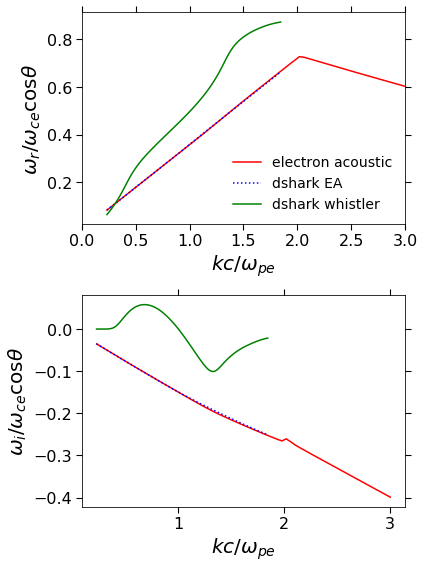

In [121]:
plt.figure(figsize=[6, 8])

plt.subplot(211)
plt.plot(kde_list, ea_freq_arr.real/1836/np.cos(np.deg2rad(theta)), 'r-', label = 'electron acoustic')
plt.plot(dshark_ea.k / 43, dshark_ea.wr / 1836, 'b:', label='dshark EA')
plt.plot(dshark_whistler.k/43, dshark_whistler.wr/1836, 'g-', label='dshark whistler')
# plt.plot(kde_list, whistler_freq_arr.real/1836/np.cos(np.deg2rad(theta)), '.-', label = 'whistler')
# plt.plot(kde_whistler, freq_whistler.real)
plt.xlabel('$kc/\omega_{pe}$')
plt.ylabel(r'$\omega_r/\omega_{ce} \cos \theta $')
# plt.ylim([0, 1.])
plt.xlim([0, 3])
plt.legend(frameon=False)

plt.subplot(212)
plt.plot(kde_list, ea_freq_arr.imag/1836/np.cos(np.deg2rad(theta)), 'r-', label = 'electron acoustic')
plt.plot(dshark_whistler.k/43, dshark_whistler.wi/1836, 'g', label='dshark whistler')
plt.plot(dshark_ea.k / 43, dshark_ea.wi / 1836, 'b:')
plt.xlabel('$kc/\omega_{pe}$')
plt.ylabel(r'$\omega_i/\omega_{ce} \cos \theta $')

plt.tight_layout()